# CIFAR-10

**Task description:** Take the CIFAR-10 dataset. Train a network, which is able to predict for a given input image whether an animal or a vessel is included, and whether the depicted object can fly, walk, jump or swim.

## Data

**Groud truth:**


| label |  name  | animal or vessel  | fly, walk, jump, or swim  |
|---|---|---|---|
| 0  |airplane | none | fly |
| 1  |automobile | none | none |
| 2  |bird | animal | fly, walk, jump |
| 3  |cat | animal | walk, jump, swim |
| 4  |deer | animal | walk, jump, swim |
| 5  |dog | animal | walk, jump, swim |
| 6  |frog | animal | jump, swim |
| 7  |horse | animal | walk, jump, swim |
| 8  |ship | vessel | swim |
| 9  |truck | none | none |

In [1]:
label_map = {
    0: {
        "label_name": "airplane",
        "animal_vessel": "none",
        "movement": ["fly"],
    },
    1: {
        "label_name": "automobile",
        "animal_vessel": "none",
        "movement": ["none"],
    },
    2: {
        "label_name": "bird",
        "animal_vessel": "animal",
        "movement": ["fly", "walk", "jump"],
    },
    3: {
        "label_name": "cat",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    4: {
        "label_name": "deer",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    5: {
        "label_name": "dog",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    6: {
        "label_name": "frog",
        "animal_vessel": "animal",
        "movement": ["jump", "swim"],
    },
    7: {
        "label_name": "horse",
        "animal_vessel": "animal",
        "movement": ["walk", "jump", "swim"],
    },
    8: {
        "label_name": "ship",
        "animal_vessel": "vessel",
        "movement": ["swim"],
    },
    9: {
        "label_name": "truck",
        "animal_vessel": "none",
        "movement": ["none"]
    }
}
movement_map = {
    "fly": 0,
    "walk": 1,
    "jump": 2,
    "swim": 3,
    "none": 4
}
animal_vessel_map = {
    "animal": 0,
    "vessel": 1,
    "none": 2
}

In [2]:
def transform_target(y):
    animal_vessel_idx = animal_vessel_map[label_map[y]["animal_vessel"]]
    movement_idx = [movement_map[m] for m in label_map[y]["movement"]]
    return {
        "animal_vessel": torch.tensor(animal_vessel_idx),
        "movement": torch.zeros(5, dtype=torch.float).scatter_(0, torch.tensor(movement_idx), value=1)
    }

In [3]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.CIFAR10(
    root="/tmp",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: transform_target(y))
)
test_data = datasets.CIFAR10(
    root="/tmp",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: transform_target(y))
)

Files already downloaded and verified
Files already downloaded and verified


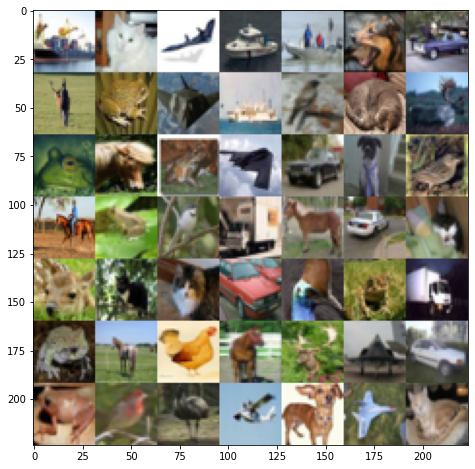

In [4]:
import matplotlib.pyplot as plt

n = 49
sample = torch.stack([training_data[i.item()][0] for i in torch.randint(0, len(training_data), (n, ))])
plt.figure(figsize=(8, 8))
plt.imshow(torch.hstack(torch.unbind(sample.movedim(1, 3).reshape(int(n**(1/2)), -1, 32, 3))))

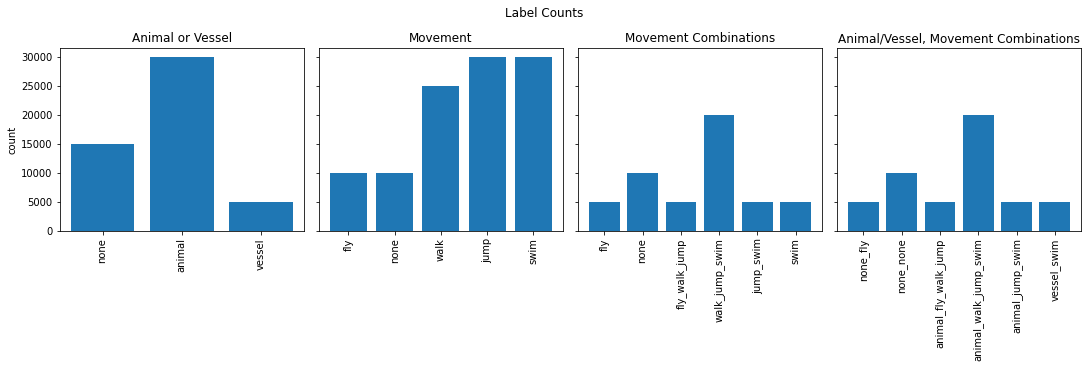

In [5]:
# label distribution can be computed based on the frequencies of the original labels
# https://www.cs.toronto.edu/~kriz/cifar.html
import collections

images_per_class = 5000# + 1000
animal_vessel_freq = collections.defaultdict(int)
movement_freq = collections.defaultdict(int)
movement_comb_freq = collections.defaultdict(int)
animal_movement_comb_freq = collections.defaultdict(int)
for label in label_map.values():
    animal_vessel_freq[label["animal_vessel"]] += images_per_class
    for m in label["movement"]:
        movement_freq[m] += images_per_class
    movement_comb_freq["_".join(label["movement"])] += images_per_class
    animal_movement_comb_freq["_".join([label["animal_vessel"]]+label["movement"])] += images_per_class
    

fig, ax = plt.subplots(1, 4, sharey=True, constrained_layout=True, figsize=(15, 5))
for i, d in enumerate([animal_vessel_freq, movement_freq, movement_comb_freq, animal_movement_comb_freq]):
    ax[i].bar(range(len(d)), list(d.values()), tick_label=list(d.keys()))
    ax[i].tick_params("x", labelrotation=90)
ax[0].set_ylabel("count")
ax[0].set_title("Animal or Vessel")
ax[1].set_title("Movement")
ax[2].set_title("Movement Combinations")
ax[3].set_title("Animal/Vessel, Movement Combinations")
fig.suptitle("Label Counts")
plt.show()

## Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SmallAlexNet(nn.Module):
    # https://en.wikipedia.org/wiki/AlexNet
    def __init__(self, dropout=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 120, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(120 * 6 * 6, 84),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(84, 10),
            nn.ReLU(inplace=True)
        )
        self.animal_vessel = nn.Sequential(
            nn.Linear(10, 3),
            #nn.Softmax(inplace=True)
        )
        self.movement = nn.Sequential(
            nn.Linear(10, 5),
            #nn.Sigmoid(inplace=True)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear_relu_stack(x)
        return {
            "animal_vessel": self.animal_vessel(x),
            "movement": self.movement(x),
        }

In [7]:
def loss_fn(output, target):
    cross_entropy = F.cross_entropy(output["animal_vessel"], target["animal_vessel"])
    binary_cross_entropy = F.binary_cross_entropy_with_logits(output["movement"], target["movement"])
    return cross_entropy + binary_cross_entropy

## Training

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(pred, target, threshold=0.5):
    pred["animal_vessel"] = pred["animal_vessel"].argmax(axis=1)
    pred["movement"] = np.array(pred["movement"] > threshold, dtype=float)
    average_params = ["micro", "macro"]
    metrics = dict(zip(pred.keys(), [dict(), dict()]))
    for objective in pred.keys():
        metrics[objective]["accuracy"] = accuracy_score(target[objective], pred[objective])
        for ap in average_params:
            metrics[objective].update({
                f"precision_{ap}": precision_score(target[objective], pred[objective], average=ap, zero_division=0),
                f"recall_{ap}": recall_score(target[objective], pred[objective], average=ap, zero_division=0),
                f"f1_{ap}": f1_score(target[objective], pred[objective], average=ap, zero_division=0),
            })
    return metrics

In [31]:
from tqdm import tqdm
import sys

def train_loop(epoch_index):
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    running_loss = 0
    for i, (X, y) in enumerate(tqdm(train_dataloader, desc=f"Train loop", file=sys.stdout)):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            n_iter = epoch_index * num_batches + i + 1
            writer.add_scalar("Loss/train", last_loss, n_iter)
            running_loss = 0
    return last_loss
            
def test_loop(epoch_index, best_loss, save=True):
    num_batches = len(test_dataloader)
    test_loss = 0
    metrics = {
        "animal_vessel": collections.defaultdict(float),
        "movement": collections.defaultdict(float),
    }
    with torch.no_grad():
        for X, y in tqdm(test_dataloader, desc=f"Test loop", file=sys.stdout):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            batch_metrics = calculate_metrics(pred, y)
            for objective, d in batch_metrics.items():
                for metric, val in d.items():
                    metrics[objective][metric] += val
    test_loss /= num_batches
    for objective, d in metrics.items():
        for metric, val in d.items():
            metrics[objective][metric] /= num_batches
    return test_loss, metrics

In [32]:
from torch.utils.data import DataLoader

learning_rate = 1e-3
batch_size = 4

model = SmallAlexNet()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [33]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"runs/cifar10_{timestamp}")
best_loss = np.inf

epochs = 35
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(t)
    test_loss, metrics = test_loop(t, best_loss)
    writer.add_scalars(
        "Training vs. Test Loss",
        {"Training": train_loss, "Test": test_loss},
        t+1
    )
    for metric in metrics["animal_vessel"].keys():
        writer.add_scalars(
            metric,
            {
                "Animal/Vessel": metrics["animal_vessel"][metric],
                "Movement": metrics["movement"][metric]
            },
            t+1
        )
    writer.flush()
    if test_loss < best_loss:
        best_loss = test_loss
        model_path = f"models/model_{timestamp}_{t}"
        torch.save(model.state_dict(), model_path)
        
    print(
        (f"Train loss: {train_loss:>7f}, "
        f"Test loss: {test_loss:>8f}\n"
        "Animal/Vessel: "
        f"Accuracy: {(100*metrics['animal_vessel']['accuracy']):>0.1f}%, "
        f"precision: {metrics['animal_vessel']['precision_micro']:>8f}, "
        f"recall: {metrics['animal_vessel']['recall_micro']:>8f} "
        f"f1: {metrics['animal_vessel']['f1_micro']:>8f}\n"
        "Movement: "
        f"Accuracy: {(100*metrics['movement']['accuracy']):>0.1f}%, "
        f"precision: {metrics['movement']['precision_micro']:>8f}, "
        f"recall: {metrics['movement']['recall_micro']:>8f}, "
        f"f1: {metrics['movement']['f1_micro']:>8f}\n")
    )
train_time = datetime.now() - datetime.strptime(timestamp, "%Y%m%d_%H%M%S")
print(f"Finished Training (training time: {str(train_time)})")

Epoch 1
-------------------------------
Test loop: 100%|██████████| 2500/2500 [01:00<00:00, 41.08it/s]
Train loss: 0.966007, Test loss: 1.022002
Animal/Vessel: Accuracy: 76.2%, precision: 0.761800, recall: 0.761800 f1: 0.761800
Movement: Accuracy: 40.1%, precision: 0.811276, recall: 0.607771, f1: 0.674659

Epoch 2
-------------------------------
Train loop:  10%|▉         | 1212/12500 [00:14<02:17, 82.00it/s]


KeyboardInterrupt: 

In [ ]:
!tensorboard --logdir=runs